# 一般化線形モデル：階層化線形回帰
ここでは以下のことを行う
- 階層化ベイジアンモデリングの直観的説明
- 階層化ベイジアンモデリングの有効性の実証と、非階層化モデリングとの比較
- **縮小効果**(shrinkage effect)の可視化
- 頻度主義的視点とのつながり


- 「課題個々にフィッティングさせる」：各々には類似性がないという前提
- 「すべてのデータを１つにまとめて１モデルで予測」：課題はすべて同一であるという前提

※ HDDM(Hierarchical Drift Diffusion Model)を使うとより簡単にでk流らしいが、今回はもっと古典的手法で行う。

## 課題テーマ： 家の中のラドン濃度レベルの予測
- データセット：Gelman radon dataset
- 放射性ラドンの量が家ごと、州ごとに測定されている
    * 家の土壌によって濃度が違うと知られている


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import xarray as xr

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.5


In [9]:
data = pd.read_csv(pm.get_data("radon.csv"))
county_names = data.county.unique()

data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
data[["county", "log_radon", "floor"]].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


わかりやすいモデル１：データを１纏めにして、単回帰するわ  
 $$ \it{radon}_{i, c} = \alpha + \beta * \rm{floor}_{i, c} + \epsilon $$


わかりやすいモデル２：群(county)ごとにデータを分けて、それぞれで単回帰するわ
 $$ \it{radon}_{i, c} = \alpha_c + \beta_c * \rm{floor}_{i, c} + \epsilon_c $$
- データが少なくなりやすく、ノイズが増えやすい
- `c`(subindex): よって、n個の別々の群に対して$\alpha_{s}$と$\beta_{s}$を求める必要がある。

わかりやすいモデル３：**部分プーリング**、つまり階層化回帰による１、２の両者いいとこどり
$\alpha_{s}$と$\beta_{s}$は群によって別々であるとしながら、それらは同一の分布からサンプリングされるものとする。つまり、
$$ \alpha_c  \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$ \beta_c  \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2)$$
従って、$\mu$と$\sigma$を推定することが問題になる。→階層モデリングと呼ばれる所以。



### 非階層型モデリングでやった場合

In [23]:
county_idxs, counties = pd.factorize(data.county)
print(f"{data.county[:5]=}")
print(f"{county_idxs[:5]=}")
print(f"{counties[:5]=}")
assert len(data.county) == len(county_idxs)
assert len(np.unique(data.county)) == len(counties)
print(len(data.county), len(county_idxs), len(counties))

coords = {
    "county": counties, 
    "obs_id": np.arange(len(county_idxs)),
}

data.county[:5]=0    AITKIN
1    AITKIN
2    AITKIN
3    AITKIN
4     ANOKA
Name: county, dtype: object
county_idxs[:5]=array([0, 0, 0, 0, 1])
counties[:5]=Index(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON'], dtype='object')
919 919 85


In [21]:
with pm.Model(coords=coords) as unpooled_model:
     county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
     floor = pm.Data("floor", data.floor.values, dims="obs_id")

     a = pm.Normal("a", mu=0, sigma=100, dims="county")   # countyのuniqueな数分だけ作る
     b = pm.Normal("b", mu=0, sigma=100, dims="county")   # countyのuniqueな数分だけ作る

     eps = pm.HalfCauchy("eps", 5)

     radon_est = a[county_idx] + b[county_idx] * floor

     y = pm.Normal("y", radon_est, sigma=eps, observed=data.log_radon, dims="obs_id")

with unpooled_model:
     unpooled_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


### 階層型モデリングで行った場合
- モデルを別々に作るのではなく、共通した類似性を持つ群＝グループパラメータを作り出す
- これらの分布は各群の$\alpha$, $\beta$の分布に影響を及ぼすために使われる！

In [24]:
with pm.Model(coords=coords) as hierarchical_model:
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b= pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sigma to a fixed value while here we plug in 
    # a common group distribution for all a and b (which are vectors of length n_counties)
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="county")
    # effect diff btw basement and floor level
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like",
                           mu=radon_est,
                           sigma=eps,
                           observed=data.log_radon,
                           dims="obs_id",  # id(つまりcounty?)の個数分作る
                           )       


In [25]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 600x500 with 0 Axes>

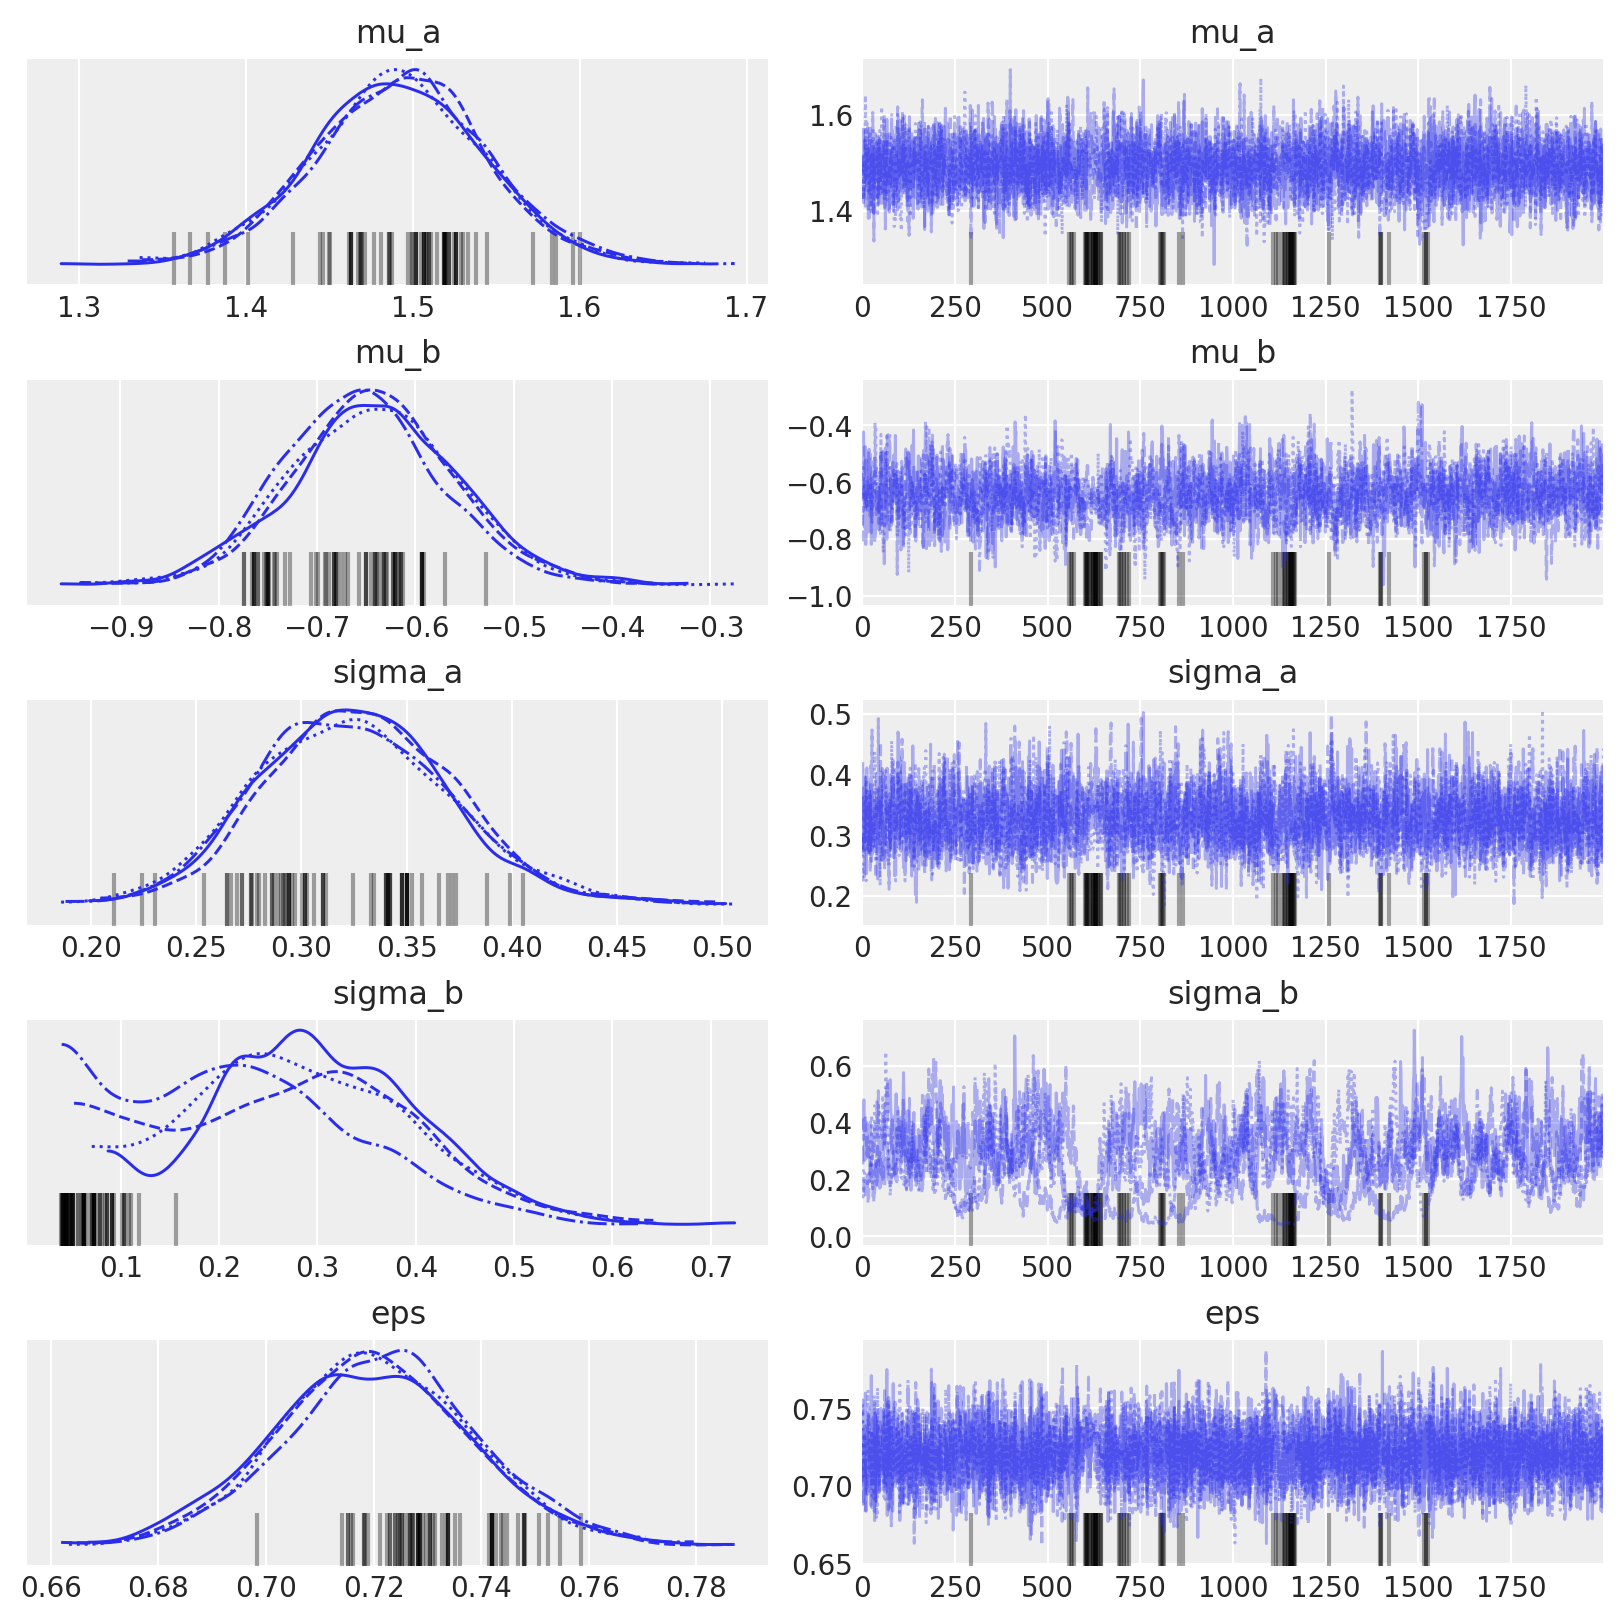

In [40]:
plt.figure(figsize=(6,5))
# hierarchical_chain = hierarchical_trace[100:]
az.plot_trace(hierarchical_trace, 
              var_names=["mu_a", "mu_b", "sigma_a", "sigma_b", "eps"],
              figsize=(8,8)
              )
plt.tight_layout()
plt.show()

array([[<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>]], dtype=object)

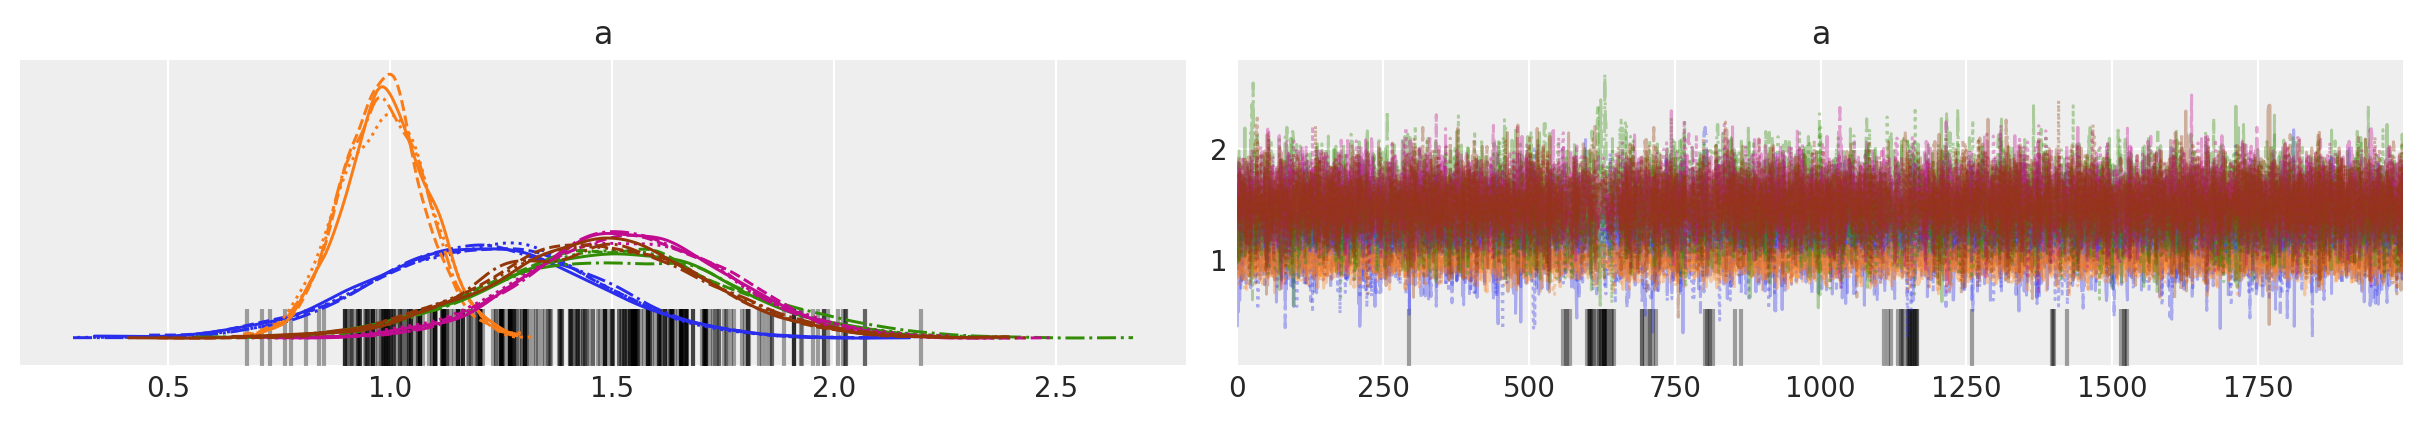

In [34]:
az.plot_trace(hierarchical_trace, var_names=["a"],
              coords={"county": counties[:5]})

↑非常に面白い示唆が得られる
1. `mu_a`: group mean (log) radnon levels. 
1. `mu_b`: having no basement decreased radon levels significantly
1. `a`: countyごとに色分けされている。幅の違いがある。つまり、各パラメータの推定にどれだけ確信度があるか。各群ごとに測定値を得るほど、確信度は高くなるはず。

## Posterior Predictive Check
上までに作った２モデルのうち、どちらが優れているかを判断するためにRoot Mean Square Deviation(RMSD)を計算する。
- chain中の異なるモーメント（？）で推定したパラメータに基づいて生成したデータを使う
- 再生成されたデータはその後にリアルデータと比較され、近い物がより良しとされる。
- よってRMSDが小さい方がベター
RMSDは計算されたものとして、
- individual/non-hierarchical model: 0.13
- hierarchical model: 0.08　→ **better!**
となったとする。



In [41]:
selection = ["CASS", "CROW WING", "FREEBORN"]
xvals = xr.DataArray(np.linspace(-0.2, 1.2, num=85), dims=["x_plot"])

unpooled_post = unpooled_trace.posterior.stack(chain_draw=("chain", "draw"))
hier_post = hierarchical_trace.posterior.stack(chain_draw=("chain", "draw"))

hier_post

<xarray.Dataset>
Dimensions:     (chain_draw: 8000, county: 85)
Coordinates:
  * county      (county) object 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * chain_draw  (chain_draw) object MultiIndex
  * chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  * draw        (chain_draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
Data variables:
    mu_a        (chain_draw) float64 1.452 1.454 1.446 1.417 ... 1.421 1.462 1.5
    mu_b        (chain_draw) float64 -0.5073 -0.5894 -0.4493 ... -0.6544 -0.5665
    a           (county, chain_draw) float64 0.3957 1.877 0.5244 ... 1.742 1.625
    b           (county, chain_draw) float64 -0.5518 -0.3468 ... -0.9076 -1.063
    sigma_a     (chain_draw) float64 0.3616 0.3273 0.305 ... 0.3074 0.388 0.4429
    sigma_b     (chain_draw) float64 0.4143 0.3759 0.3711 ... 0.4448 0.3555
    eps         (chain_draw) float64 0.7239 0.7082 0.7482 ... 0.7327 0.6931
Attributes:
    created_at:                 2022-12-20T10:08:58.592036
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              17.804840087890625
    tuning_steps:               2000

In [44]:
obs_county = unpooled_post["county"].isel(county=unpooled_trace.constant_data["county_idx"])
observed_data = unpooled_trace.observed_data.assign_coords(
    floor=unpooled_trace.constant_data["floor"]
)
observed_data

<xarray.Dataset>
Dimensions:  (obs_id: 919)
Coordinates:
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 ... 911 912 913 914 915 916 917 918
    floor    (obs_id) float64 1.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    y        (obs_id) float64 0.8329 0.8329 1.099 0.09531 ... 1.629 1.335 1.099
Attributes:
    created_at:                 2022-12-20T08:23:10.757133
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5

In [48]:
unpooled_est = (unpooled_post["a"] + unpooled_post["b"] * xvals).transpose("x_plot", ...)
hier_est = (hier_post["a"] + hier_post["b"] * xvals).transpose("x_plot", ...)

In [50]:
rng = np.random.default_rng(0)

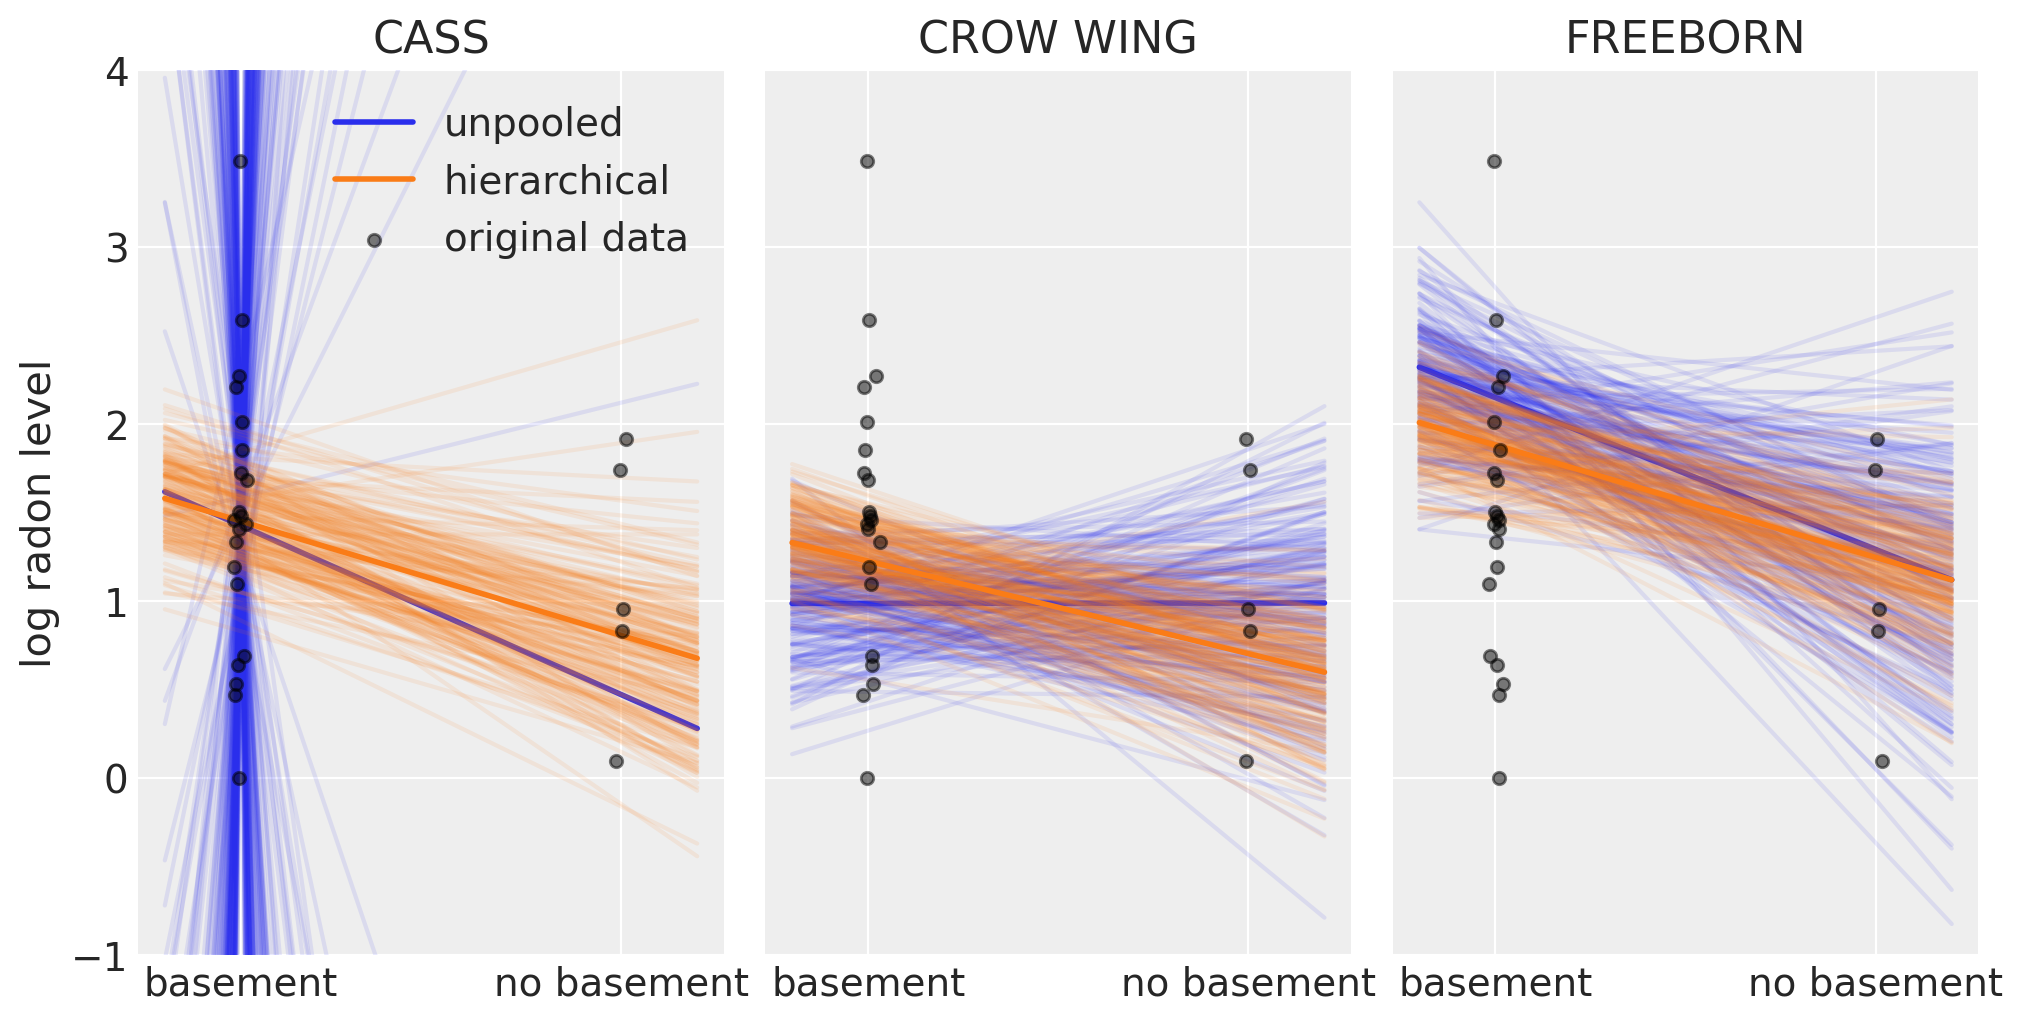

In [52]:
fig, axis = plt.subplots(1, 3, figsize=(10, 5), sharey=True, sharex=True)
axis = axis.ravel()

random_subset = rng.permutation(np.arange(len(hier_est["chain_draw"])))[:200]

for i, c in enumerate(selection):
    ### unpooled model ###
    unpooled_c = unpooled_est.sel(county=c)
    unpooled_means = unpooled_post.sel(county=c).mean()
    # plot all samples from unpooled model
    axis[i].plot(xvals, unpooled_c.isel(chain_draw=random_subset), color="C0", alpha=0.1)
    # plot mean from unpooled model
    axis[i].plot(
        xvals,
        unpooled_means["a"] + unpooled_means["b"] * xvals,
        color="C0",
        alpha=1,
        lw=2.0,
        label="unpooled",
    )
    ### hierarchical model ##
    hier_c = hier_est.sel(county=c)
    hier_means = hier_post.sel(county=c).mean()
    # plot all samples
    axis[i].plot(xvals, hier_c.isel(chain_draw=random_subset), color="C1", alpha=0.1)
    # plot mean
    axis[i].plot(
        xvals,
        hier_means["a"] + hier_means["b"] * xvals,
        color="C1",
        alpha=1,
        lw=2.0,
        label="hierarchical",
    )
    # observed_data
    obs_data_c = observed_data.where(obs_county.isin(selection), drop=True)
    axis[i].scatter(
        obs_data_c["floor"] + rng.normal(scale=0.01, size=len(obs_data_c["floor"])),
        obs_data_c["y"],
        alpha=0.5,
        color="k",
        marker=".",
        s=80,
        zorder=3,
        label="original data",
    )
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["basement", "no basement"])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel("log radon level")